In [1]:
import os

from PIL import Image
from ultralytics import YOLO

In [2]:
# Load a model
model = YOLO(
    "yolov8n.pt"
    )

# Use the model
results = model.train(
    data=r"D:\0_amri_local\14_pupr_roaddamagedetection\yolov8_custom\data\rddc2020_use_pascal\rddc2020_use_pascal_data.yaml",
    epochs=3,
    batch=8,
    # patience=10
    )  # train the model

Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\0_amri_local\14_pupr_roaddamagedetection\yolov8_custom\data\rddc2020_use_pascal\rddc2020_use_pascal_data.yaml, epochs=3, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=Fa

In [3]:
# Load a pretrained YOLOv8n model
best_model = YOLO(r'D:\0_amri_local\14_pupr_roaddamagedetection\yolov8_custom\notebooks\yolov8n_custom.pt')

In [12]:
# Run inference on an image
results = model(r'D:\0_amri_local\14_pupr_roaddamagedetection\yolov8_custom\notebooks\Japan_012998.jpg')  # list of 1 Results object


image 1/1 D:\0_amri_local\14_pupr_roaddamagedetection\yolov8_custom\notebooks\Japan_012998.jpg: 640x640 (no detections), 32.8ms
Speed: 8.4ms preprocess, 32.8ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)


In [11]:
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image

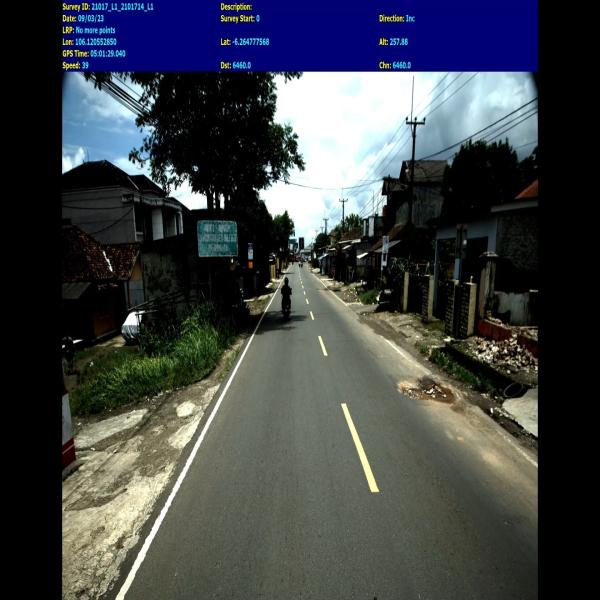

In [10]:
im